In [2]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
import sys
sys.path.append('../')

# from scripts.compute_decoupled_cl import compute_decoupled_cl
from scripts.compute_weights import compute_weights
from scripts.compute_alm_ilc import compute_alm_ilc
from scripts.mask_maps import mask_maps
# from scripts.cosine_smoothed_mask import cosine_smoothed_mask
from scripts.generate_noise import generate_noise
from scripts.sigma_noise import sigma_noise

In [3]:
nside=256
factor=1e7
freqs=np.arange(544,1088,step=1)
nfreqs=len(freqs)
lmax=3*nside -1


In [3]:
smoothed_maps_1=np.load("/home/iloveorcas/MASS_Thesis/results/smoothed_maps_1.npy")

In [4]:
smooth_cl= hp.anafast(smoothed_maps_1[0,:], lmax=lmax)

In [5]:
smooth_cl.shape

(768,)

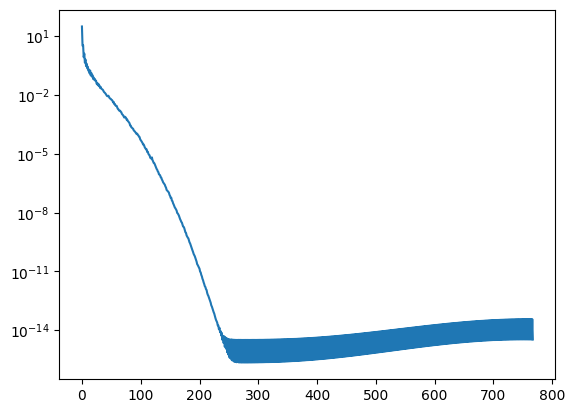

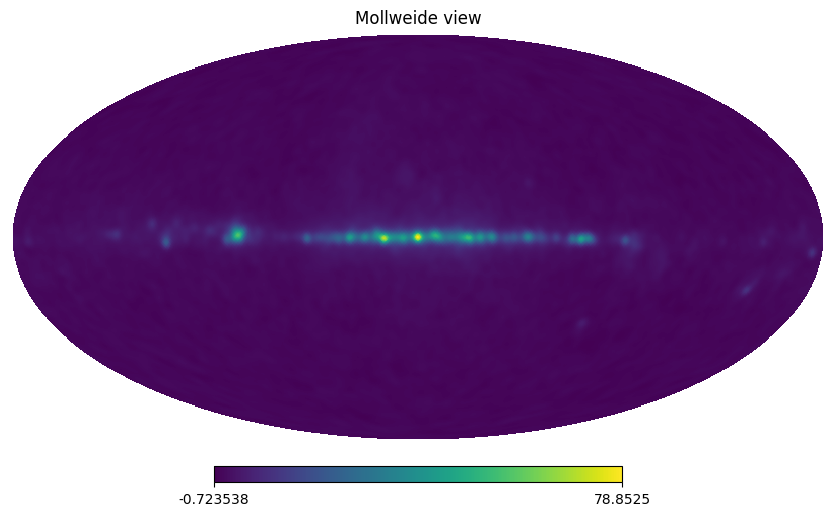

In [6]:
plt.plot(smooth_cl)
plt.yscale("log")
hp.mollview(smoothed_maps_1[0])

In [87]:
def compute_decoupled_cl( maps: np.ndarray, masks:np.ndarray, X:bool, nsides:int, lmax:int, n_freq:int)-> np.ndarray:
    """
    Compute the power spectra using NaMaster for a set of frequency maps.

    Parameters:
    - maps: numpy array of shape (n_freqs, n_maps) containing the frequency maps
    - masks: mask to apply to the maps
    - X: flag to indicate if the input maps are masked
    - nsides: resolution parameter for the maps
    - l_max: maximum multipole for the power spectra
    - n_freq: number of frequency channels

    Returns:

    - cldec: decoupled power spectrum
    """
    p_cl =np.zeros((lmax+1, n_freq, n_freq))
    cldec = np.zeros((lmax+1, n_freq, n_freq))
    

    # Loop over all pairs of frequency maps (cross-power spectra)
    for i in range(n_freq):
        print(f"Decoupling map {i}")
        for j in range(i, n_freq):  # Compute only upper triangle (symmetric matrix)

            # Define the masked fields for the two maps
            f_i = nmt.NmtField(1 - masks, [maps[i, :]], masked_on_input=X) 
            f_j = nmt.NmtField(1 - masks, [maps[j, :]], masked_on_input=X) 

            # Compute the coupled power spectrum for (i, j)
            p_cl[:, i, j] = nmt.compute_coupled_cell(f_i, f_j)
            


            # Define a NaMaster binning scheme (no binning)
            b = nmt.NmtBin.from_nside_linear(nsides, 1)

            # Create NaMaster workspace and get the coupling matrix
            w = nmt.NmtWorkspace.from_fields(f_i, f_j, b)
            #w = nmt.NmtWorkspace()
            w.compute_coupling_matrix(f_i, f_j, b)
        
            #w.compute(f_i, f_j, b)
            matrix = w.get_coupling_matrix() #lxl

            # Compute the inverse of the mode-coupling matrix
            matrix_inv = np.linalg.pinv(matrix, rcond=1e-6)

            # Compute the decoupled power spectrum using Einstein summation
            cldec[:, i, j] = np.einsum('ij,j->i', matrix_inv, p_cl[:, i, j])
            # cldec[2:,i,j] = nmt.compute_full_master(f_i, f_j, b)

            # Since Cl is symmetric, copy the value to (j, i)
            if i != j:
                cldec[:, j, i] = cldec[:, i, j]
                p_cl[:, j, i] = p_cl[:, i, j]
    return cldec

In [4]:
def cosine_smoothed_mask(nside):
    """Creates a HEALPix mask that smoothly transitions along the Galactic plane as a cosine."""
    
    npix = hp.nside2npix(nside)  # Number of HEALPix pixels
    theta, phi = hp.pix2ang(nside, np.arange(npix))  # Get theta, phi for all pixels
    
    # Convert colatitude to Galactic latitude b
    #HEALPix colatitude 𝜃 to Galactic latitude b

    b = 90 - np.degrees(theta)
    bmin= 2
    bmax=10

    # Initialize mask
    mask = np.zeros(npix)

    # Apply cosine smoothing in the range 8° < |b| < 10°
    transition = (np.abs(b) > bmin) & (np.abs(b) < bmax)
    mask[transition] = 0.5 * (1 - np.cos(np.pi * (np.abs(b[transition]) - bmin) / (bmax-bmin)))

    # Set mask to 1 for |b| ≥ 10°
    mask[np.abs(b) >= bmax] = 1
    # mask2= (mask2*(-1))+1 FIX CODES FOR THIS

    return mask

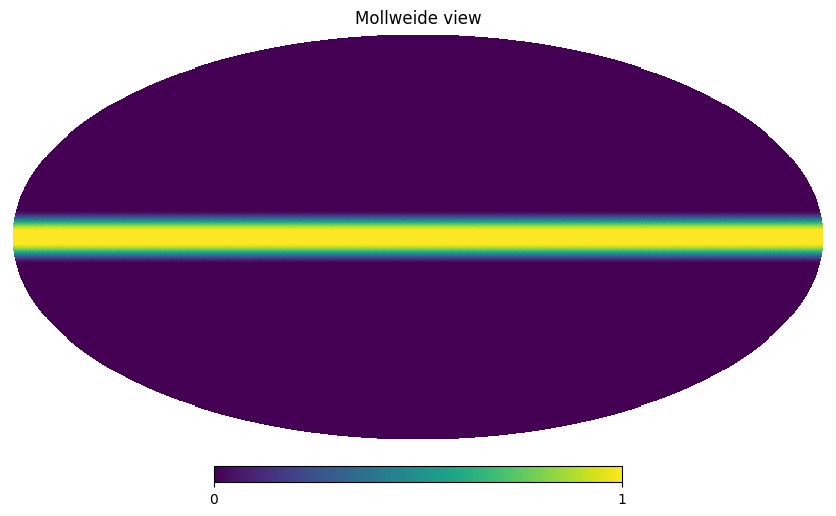

In [5]:
mask=cosine_smoothed_mask(nside)
mask= (mask*(-1))+1
hp.mollview(mask)

In [6]:
def compute_master (maps: np.ndarray, masks:np.ndarray, X:bool, nsides:int, l_max:int, n_freq:int)-> np.ndarray:

    cldec = np.zeros((lmax-1, n_freq, n_freq))
    

    # Loop over all pairs of frequency maps (cross-power spectra)
    for i in range(n_freq):
        print(f"Decoupling map {i}")
        for j in range(i, n_freq):  # Compute only upper triangle (symmetric matrix)

            # Define the masked fields for the two maps
            f_i = nmt.NmtField(1 - masks, [maps[i, :]], masked_on_input=X, lmax=l_max) 
            f_j = nmt.NmtField(1 - masks, [maps[j, :]], masked_on_input=X, lmax=l_max) 
            
            # Define a NaMaster binning scheme (no binning)
            b = nmt.NmtBin.from_nside_linear(nsides, 1)

            cldec[:,i,j] = nmt.compute_full_master(f_i, f_j, b)

            # Since Cl is symmetric, copy the value to (j, i)
            if i != j:
                cldec[:, j, i] = cldec[:, i, j]
                
    return cldec

(786432,)
(786432,)


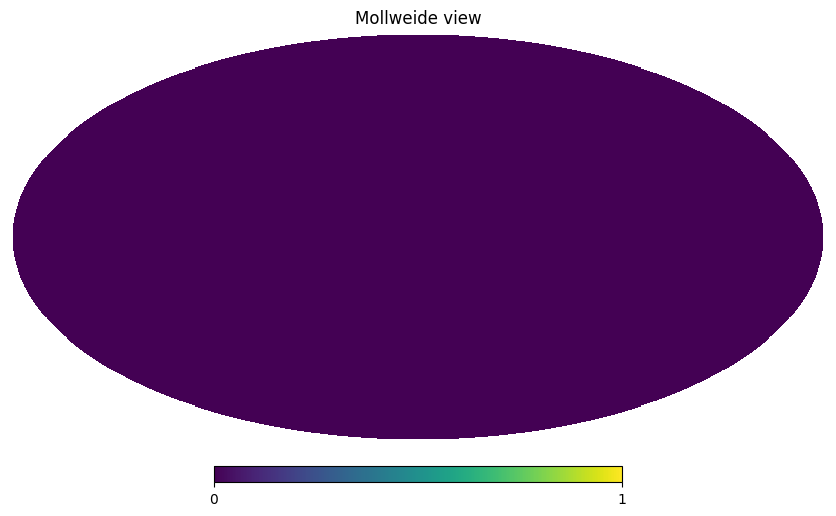

In [7]:
fakemask=np.zeros(mask.shape)
hp.mollview(fakemask, min=0, max=1)
print(fakemask.shape)
print(mask.shape)

In [8]:
less_smoothed=np.load("smoothed_maps_1_smallbeam.npy") #beam fwhm decreased by  a factor of 100

In [15]:
master= compute_master(less_smoothed[:10], fakemask, False, nside, lmax, 10)

Decoupling map 0
Decoupling map 1
Decoupling map 2
Decoupling map 3
Decoupling map 4
Decoupling map 5
Decoupling map 6
Decoupling map 7
Decoupling map 8
Decoupling map 9


In [12]:
cl_dec= compute_decoupled_cl(less_smoothed[:10], mask, False, nside, lmax, 10)

NameError: name 'compute_decoupled_cl' is not defined

In [27]:
print(master.shape)

(768, 10, 10)


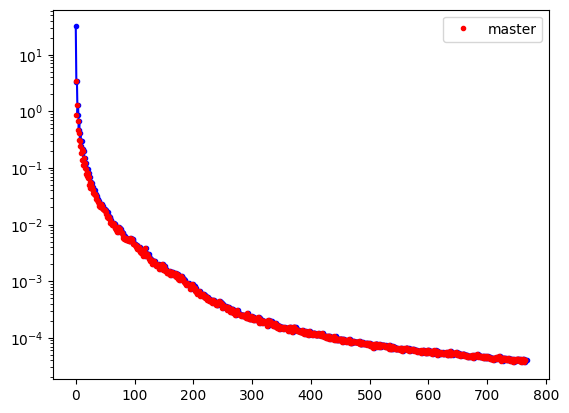

In [16]:
lesssmooth_cl= hp.anafast(less_smoothed[0,:], lmax=lmax)
plt.plot(lesssmooth_cl, 'b.-')
plt.plot(master[:,0,0], 'r.', label="master")
# plt.plot(cl_dec[:,0,0],'g.', label="decoupled")
plt.yscale("log")
plt.legend()

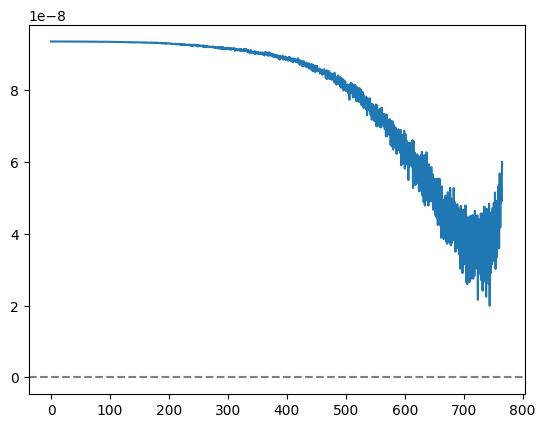

In [17]:
plt.plot((-lesssmooth_cl[2:]+master[:,0,0])/master[:,0,0])
plt.axhline(0, linestyle="--", color="gray")